# Plots paper: TSM: Measuring the Enticement of Honeyfiles with Natural Language Processing

This notebook contains the code that creates the graph of the TSM enticement score paper:

@inProceedings{timmer2022tsm,
  title={TSM: Measuring the Enticement of Honeyfiles with Natural Language Processing},
  author={Timmer, Roelien and Liebowitz, David and Nepal, Surya and Kanhere, Salil},
  booktitle={Proc. the 55th Hawaii Int. Conf. Syst. Sci.},
  year={2022}
}

## Load models, deception files, etc.

In [1]:
import itertools as it, numpy as np, pandas as pd, sys
import os, spacy, json, ast, glob, warnings, collections
import seaborn as sns, matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..', 'src')))
import heatmaps as hm
warnings.filterwarnings(action='once')
cwd = os.getcwd()
path_output = os.path.abspath(os.path.join(cwd,'..', 'data/processed'))
path_plots = os.path.abspath(os.path.join(cwd,'..', 'plots'))
dec_paths = np.load(os.path.abspath(os.path.join(cwd,'..', 'data/processed/dec_paths'))+'.npy',allow_pickle=True)
categories = ['computer', 'plants', 'theater', 'customs']
labels = ['Computer\nArchitecture', 'Plants', 'Theater', 'Customs']

## Figure 7. Aggregating the top 0.5% semantic similarities give similar results to TSM with threshold.

3it [00:00, 28.48it/s]
/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


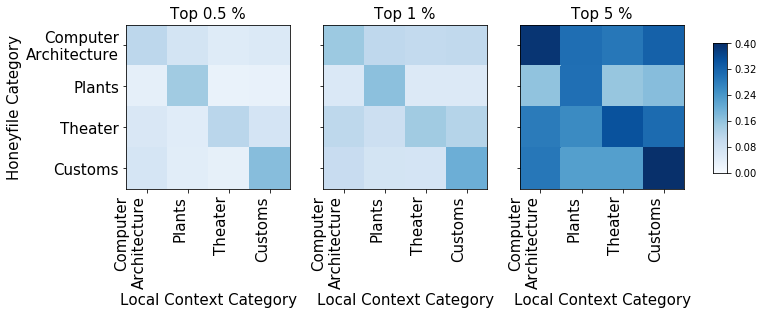

In [2]:
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN
i=0
for pp, perc in enumerate([0.5, 1, 5]):
    with open(path_output+'/local_context_topics_dict_10', 'r') as f:
        topics = json.load(f, object_pairs_hook=OrderedDict)
    topics = OrderedDict(sorted(topics.items()))
    score = np.load(path_output+'/lda_score_top_percent_'+str(perc)+"_10.npy") 
    matrix, i = hm.select_data('normal',score, topics, dec_paths, categories, 50, 'lda_score_top_percent', 10, perc,i, matrix)
df = hm.data_df(matrix,'top_percentage')    

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.94, .35, .02, .3])
df['value'] = df['value'].astype(float)

percentages = [0.5, 1, 5]

for pp, perc in tqdm(enumerate(percentages)):
    data = df[(df['deception file generation method'] == 'normal')\
              & (df['scoring measure'] == 'lda_score_top_percent')\
              & (df['top_percentage'] == perc)\
              & (df['nr. of files per local context'] == 10)\
              & (df['percentile'] == 50)]  
    selection = data['value'].values.reshape([4,4])
    sns.heatmap(selection, xticklabels=labels, yticklabels=labels, \
                cmap="Blues", ax=axs[pp], cbar=True, vmin=0, vmax=.4, cbar_ax=cbar_ax) 
    axs[pp].set_label('deception file category')
    axs[pp].set_label('local context file category')
    axs[pp].set_yticklabels(labels, rotation = 0, ha="right", fontsize=15)
    axs[pp].set_xticklabels(labels, rotation = 90, ha="right", fontsize=15)
    axs[0].set_ylabel("Honeyfile Category", fontsize=15)
    axs[pp].set_xlabel("Local Context Category", fontsize=15)
    axs[pp].set(adjustable='box', aspect='equal')
    hm.frame(pp, axs)    
hm.frame(None, cbar_ax)  
cbar_ax.set_frame_on(True) 
for ax, col in zip(axs, [0.5, 1, 5]):
    ax.set_title('Top ' + str(col) + ' %', fontsize=15)

fig.savefig(path_plots + "/figure7.svg", bbox_inches='tight')
fig.show()

## Figure 4. The 50th percentile of the enticement scores between the honeyfiles matched with local context files.

/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


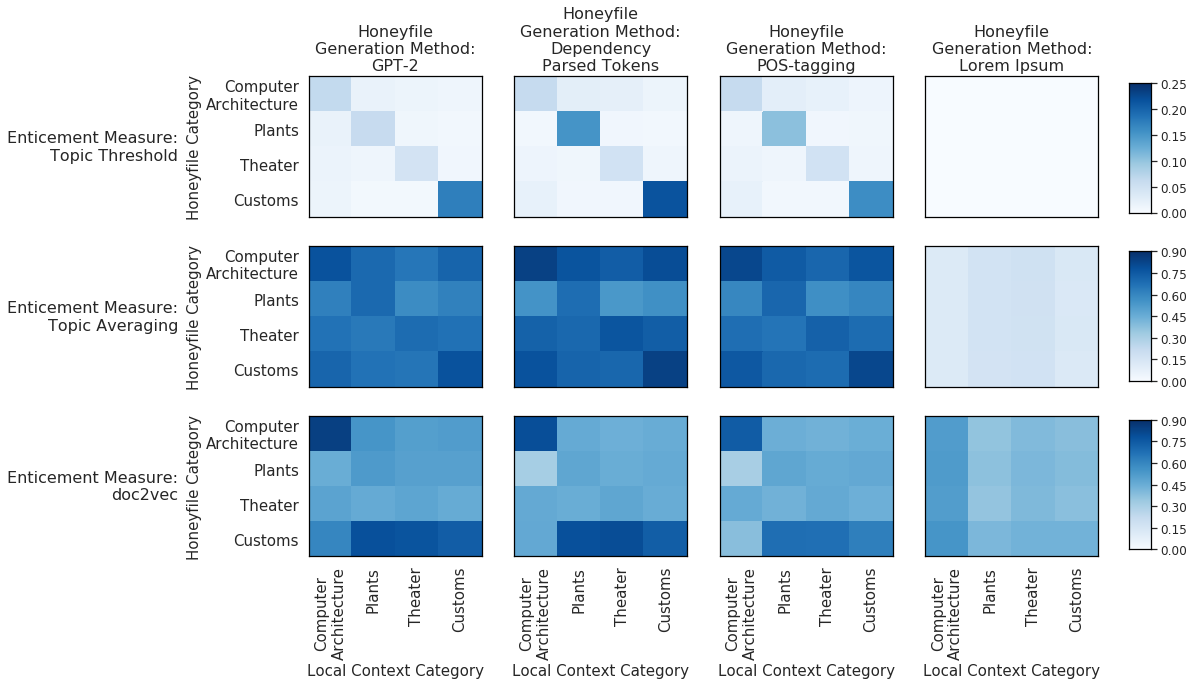

In [3]:
methods = ['gpt', 'lorem', 'pos_words', 'dependency_parsed_tokens']
percentile = [25, 50, 75]
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN

with open(path_output+'/local_context_topics_dict_10', 'r') as f:
    topics = json.load(f)
topics = OrderedDict(sorted(topics.items())) 

i = 0 
for ss, s in enumerate(['lda_score_average', 'lda_score_with_threshold', 'score_doc2vec']):
    if 'threshold' in s:
        score = np.load(path_output+'/'+str(s)+"_0.9_10.npy")
    elif 'average' in s:
        score = np.load(path_output+'/'+str(s)+"_10.npy")
    else:
        score = np.load(path_output+'/'+str(s)+"_10.npy")

    categories_vector = []
    for key, value in topics.items():
        categories_vector.extend([key]*len(value))   
    score_df = pd.DataFrame(score, index = categories_vector, columns = dec_paths)
    del score
    score_df["categories_local_context"] = categories_vector
    score_df = score_df.melt(id_vars=["categories_local_context"], var_name=["dec_paths"], value_name = 'score')
    score_df.loc[score_df['dec_paths'].str.contains('customs|ABF|abf|\d{4}-\d{2}'), 'category_deception_file'] = 'customs'
    score_df.loc[score_df['dec_paths'].str.contains('plants|wild-useful-herbs-of-aktobe-region-western'), 'category_deception_file'] = 'plants'
    score_df.loc[score_df['dec_paths'].str.contains('computer|08552374'), 'category_deception_file'] = 'computer'
    score_df.loc[score_df['dec_paths'].str.contains('theater|0021989420918654'), 'category_deception_file'] = 'theater'
    score_df["method"] = np.nan
    score_df.loc[score_df['dec_paths'].str.contains('lorem'), 'method'] = 'lorem'
    score_df.loc[score_df['dec_paths'].str.contains('pos_words'), 'method'] = 'pos_words'
    score_df.loc[score_df['dec_paths'].str.contains('dependency_parsed_tokens'), 'method'] = 'dependency_parsed_tokens'
    score_df.loc[score_df['dec_paths'].str.contains('gpt_variant2'), 'method'] = 'gpt_variant2'
    score_df.loc[score_df['dec_paths'].str.contains('gpt_variant1'), 'method'] = 'gpt_variant1'
    score_df.loc[score_df['dec_paths'].str.contains('unknown'), 'method'] = 'unknown'
    score_df = score_df[~score_df.dec_paths.str.contains("unknown")]
    
    score_df['score'] = (score_df['score']-min(score_df['score']))/(max(score_df['score'])-min(score_df['score'])) 
    
    for met in methods: 
        if met == 'gpt':
            selection1 = score_df[(score_df['method']=='gpt_variant1') | (score_df['method']=='gpt_variant2')]
        else:
            selection1 = score_df[(score_df['method']==met)]
        for cat1 in categories:
            for cat2 in categories:
                selection2 = selection1[(selection1['category_deception_file']==cat1)&(selection1["categories_local_context"]==cat2)]
                for p in percentile:
                    matrix[i,0]=met
                    matrix[i,1]=cat1
                    matrix[i,2]=cat2
                    matrix[i,3]=p
                    matrix[i,4]=np.percentile(selection2['score'],  p)
                    matrix[i,5]=s
                    matrix[i,6]=10
                    matrix[i,7]=0.9
                    i+=1   
                del selection2

df = hm.data_df(matrix,'threshold')    

scoring_measure = ['lda_score_with_threshold', 'lda_score_average', 'score_doc2vec']
method = ['gpt', 'dependency_parsed_tokens', 'pos_words', 'lorem']
sns.set(font_scale=1.1)
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,9), sharey=True, sharex=True)
cbar_ax1 = fig.add_axes([.91, .74, .02, .2])
cbar_ax2 = fig.add_axes([.91, .48, .02, .2])
cbar_ax3 = fig.add_axes([.91, .22, .02, .2])

ind = 0
for mm, m in enumerate(method):
    for i, sm in enumerate(scoring_measure):
        df['value'] = df['value'].astype(float)
        data = df[(df['deception file generation method'] == m) & (df['scoring measure'] == sm)\
              & (df['threshold'] == 0.9) & (df['nr. of files per local context'] == 10) & (df['percentile'] == 50)]         
        selection = data['value'].values.reshape([4,4])
        if sm == 'lda_score_with_threshold':
            vmin = 0
            vmax = 0.25
            res = sns.heatmap(selection, xticklabels=labels, yticklabels=labels, cmap="Blues", ax=axs[i, ind], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax1) 
            res.set_yticklabels(labels, fontsize = 15)
        elif sm == 'lda_score_average':
            vmin = 0
            vmax = 0.9
            res = sns.heatmap(selection, xticklabels=labels, yticklabels=labels, cmap="Blues", ax=axs[i, ind], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax2) 
            res.set_yticklabels(labels, fontsize = 15)
        else: 
            vmin = 0
            vmax = 0.9
            res = sns.heatmap(selection, xticklabels=labels, yticklabels=labels, cmap="Blues", ax=axs[i, ind], cbar=True, vmin=vmin, vmax=vmax, cbar_ax=cbar_ax3) 
            res.set_yticklabels(labels, fontsize = 15)
            res.set_xticklabels(labels, fontsize = 15)
        for axis in ['top','bottom','left','right']:
            axs[i, ind].spines[axis].set_visible(True)
            axs[i, ind].spines[axis].set_color('black')
            axs[i, ind].spines[axis].set_visible(True)
            axs[i, ind].spines[axis].set_color('black')   
        axs[2, ind].set_xlabel("Local Context Category", fontsize=15)
        axs[i, 0].set_ylabel("Honeyfile Category", fontsize=15)
        del data, selection
    ind +=1

for axis in ['top','bottom','left','right']:
    hm.frame(None, cbar_ax1)
    hm.frame(None, cbar_ax2)
    hm.frame(None, cbar_ax3)
    
cbar_ax1.set_frame_on(True)
cbar_ax2.set_frame_on(True)
cbar_ax3.set_frame_on(True)
    
for ax, col in zip(axs[0], ["GPT-2", "Dependency\nParsed Tokens", "POS-tagging", "Lorem Ipsum"]):
    ax.set_title('Honeyfile\nGeneration Method:\n'+str(col), fontsize=16)
    
for ax, row in zip(axs[:,0], ['Topic Threshold', 'Topic Averaging', 'doc2vec']):
    ax.annotate('Enticement Measure:\n'+str(row), 
                xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', fontsize=16, ha='right', va='center')
    
fig.tight_layout(rect=[0, 0, .9, 1])
fig.subplots_adjust(left=0.15, top=0.95)

fig.savefig(path_plots + "/figure4.svg", bbox_inches='tight')
fig.show()

## Figure 6. TSM works best with a high threshold.

/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


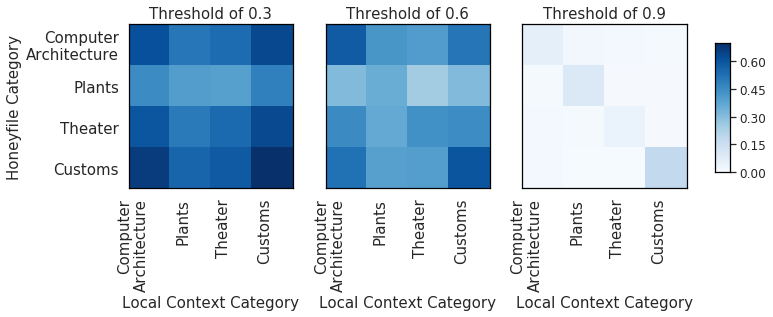

In [4]:
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN
i=0

for tt, t in enumerate([0.3, 0.6, 0.9]):
    score = np.load(path_output + "/" + 'lda_score_with_threshold'+'_'+str(t)+'_10.npy')
    with open(path_output+'/local_context_topics_dict_10', 'r') as f:
        topics = json.load(f)
    topics = OrderedDict(sorted(topics.items()))     
    matrix, i = hm.select_data('normal',score, topics, dec_paths, categories, 50, 'lda_score_with_threshold', 10, t, i, matrix)
    
df = hm.data_df(matrix,'threshold')    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.94, .35, .02, .3])

for tt, t in enumerate([0.3, 0.6, 0.9]):
    data = df[(df['deception file generation method'] == 'normal') & (df['scoring measure'] == 'lda_score_with_threshold')\
          & (df['threshold'] == t) & (df['nr. of files per local context'] == 10) & (df['percentile'] == 50)]      
    selection = data['value'].values.reshape([4,4])
    sns.heatmap(selection, xticklabels=labels, cmap="Blues", ax=axs[tt], cbar=True, vmin=0, vmax=.7, cbar_ax=cbar_ax) 
    axs[tt].set_title('Threshold of '+str(t), fontsize=15)
    axs[tt].set_yticklabels(labels, rotation = 0, ha="right", fontsize=15)
    axs[tt].set_xticklabels(labels, rotation = 90, ha="right", fontsize=15)
    axs[0].set_ylabel("Honeyfile Category", fontsize=15)
    axs[tt].set_xlabel("Local Context Category", fontsize=15)
    axs[tt].set(adjustable='box', aspect='equal')
    del data, selection
    hm.frame(tt, axs)
hm.frame(None, cbar_ax)
cbar_ax.set_frame_on(True)

fig.savefig(path_plots + "/figure6.svg", bbox_inches='tight')
fig.show()

## Figure 9. The TSM scores are comparable when the local contexts differ in size.

/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


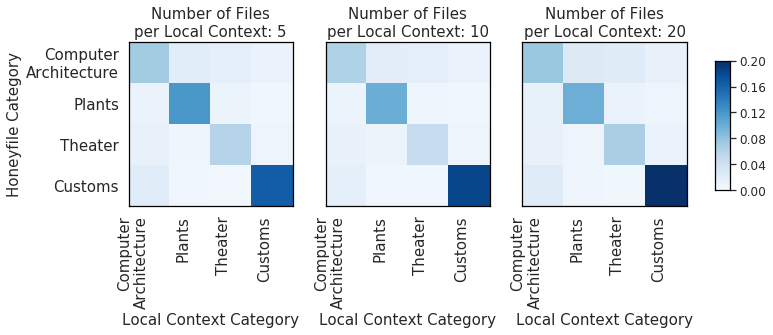

In [5]:
i=0
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN
for nn, n in enumerate([5, 10, 20]):
    score = np.load(path_output+'/'+'lda_score_with_threshold'+'_'+'0.9'+"_"+str(n)+'.npy')
    with open(path_output+'/local_context_topics_dict_' +str(n), 'r') as f:
        topics_of_local_context = json.load(f, object_pairs_hook=OrderedDict)
    topics = topics_of_local_context
    topics = OrderedDict(sorted(topics.items())) 
    matrix, i = hm.select_data('normal',score, topics, dec_paths, categories, 50, 'lda_score_with_threshold', n, 0.9, i, matrix)

df = hm.data_df(matrix,'threshold')    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.94, .35, .02, .3])

for nn, n in enumerate([5, 10, 20]):
    df['value'] = df['value'].astype(float)
    data = df[(df['deception file generation method'] == 'normal') & (df['scoring measure'] == 'lda_score_with_threshold')\
          & (df['threshold'] == 0.9) & (df['nr. of files per local context'] == n) & (df['percentile'] == 50)]   
    selection = data['value'].values.reshape([4,4])
    sns.heatmap(selection, xticklabels=labels, cmap="Blues", ax=axs[nn], cbar=True, vmin=0, vmax=.2, cbar_ax=cbar_ax) 
    axs[nn].set_title('Number of Files\nper Local Context: '+str(n), fontsize=15)
    axs[nn].set_yticklabels(labels, rotation = 0, ha="right" , fontsize=15)
    axs[nn].set_xticklabels(labels, rotation = 90, ha="right" , fontsize=15)
    axs[0].set_ylabel("Honeyfile Category", fontsize=15)
    axs[nn].set_xlabel("Local Context Category", fontsize=15)
    axs[nn].set(adjustable='box', aspect='equal')
    del data, selection
    hm.frame(nn,axs)

hm.frame(None, cbar_ax)
cbar_ax.set_frame_on(True)

fig.savefig(path_plots + "/figure9.svg", bbox_inches='tight')
fig.show()

## Distributions

/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


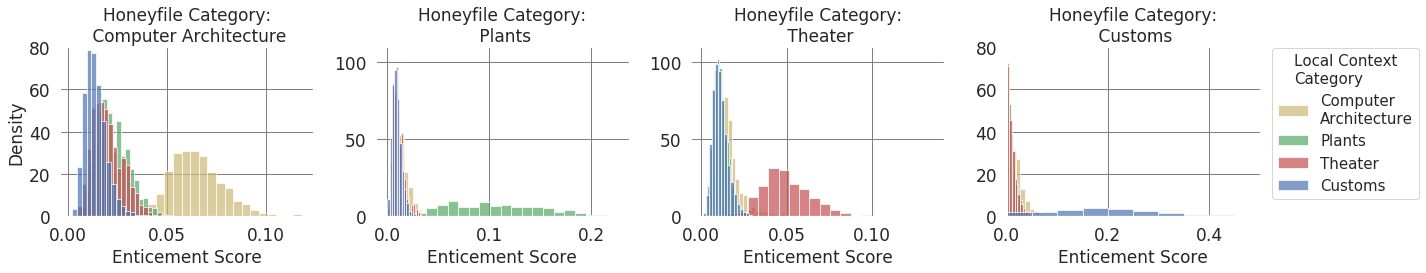

In [6]:
i=0
plt.rc('legend',**{'fontsize':15})
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN
rc = {'axes.facecolor':'white','axes.grid' : False,'grid.color': '.8',}
plt.rcParams.update(rc)
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
labels = ['Computer Architecture', 'Plants', 'Theater', 'Customs']
kwargs = dict(density=True, stacked=True)

for nn, n in enumerate([10]):
    for j, ss in enumerate(['lda_score_with_threshold']):
        score = np.load(path_output+'/'+str(ss)+'_0.9_'+str(n)+'.npy')
        categories_vector = []
        with open(path_output+'/local_context_topics_dict_' +str(n), 'r') as f:
            topics_of_local_context = json.load(f, object_pairs_hook=OrderedDict)
        topics = topics_of_local_context
        topics = OrderedDict(sorted(topics.items())) 
        for key, value in topics.items():
            categories_vector.extend([key]*len(value))
            
        score_df = pd.DataFrame(score, index = categories_vector, columns = dec_paths)
        score_df["categories_local_context"] = categories_vector
        score_df = score_df.melt(id_vars=["categories_local_context"], var_name=["dec_paths"], value_name = 'score')
        score_df.loc[score_df['dec_paths'].str.contains('customs|ABF|abf|\d{4}-\d{2}'), 'category_deception_file'] = 'customs'
        score_df.loc[score_df['dec_paths'].str.contains('plants|wild-useful-herbs-of-aktobe-region-western'), 'category_deception_file'] = 'plants'
        score_df.loc[score_df['dec_paths'].str.contains('computer|08552374'), 'category_deception_file'] = 'computer'
        score_df.loc[score_df['dec_paths'].str.contains('theater|0021989420918654'), 'category_deception_file'] = 'theater'
        score_df["method"] = np.nan
        score_df.loc[score_df['dec_paths'].str.contains('lorem'), 'method'] = 'lorem'
        score_df.loc[score_df['dec_paths'].str.contains('pos_words'), 'method'] = 'normal'
        score_df.loc[score_df['dec_paths'].str.contains('dependency_parsed_tokens'), 'method'] = 'normal'
        score_df.loc[score_df['dec_paths'].str.contains('gpt_variant2'), 'method'] = 'normal'
        score_df.loc[score_df['dec_paths'].str.contains('gpt_variant1'), 'method'] = 'normal'
        score_df.loc[score_df['dec_paths'].str.contains('unknown'), 'method'] = 'unknown'
        score_df = score_df[~score_df.dec_paths.str.contains("unknown")]
        score_df['score'] = (score_df['score']-min(score_df['score']))/(max(score_df['score'])-min(score_df['score']))
        selection1 = score_df[(score_df['method']=='normal')]
        for cc1, cat1 in enumerate(categories): 
            for cc2, (cat2, col) in enumerate(zip(categories, ['y','g','r','b'])):
                selection2 = selection1[(selection1['category_deception_file']==cat1)&(selection1["categories_local_context"]==cat2)]
                for p in [50]:
                    matrix[i,0]='normal'
                    matrix[i,1]=cat1
                    matrix[i,2]=cat2
                    matrix[i,3]=p
                    matrix[i,4]=np.percentile(selection2['score'],  p)
                    data_points = selection2['score']                    
                    if cc1%3-1 < 0:
                        y_coord = 0
                    else:
                        y_coord = i%3-1
                    x_coord = cc1%2
                    axs[cc1].hist(data_points, **kwargs,label = cat2, color=col, alpha=0.7, bins=20)
                    axs[cc1].set_title('Honeyfile Category:\n ' + labels[cc1], fontsize=17)
                    axs[cc1].set_xlabel('Enticement Score', fontsize=17)  
                    axs[cc1].xaxis.set_tick_params(labelsize=17)
                    axs[cc1].yaxis.set_tick_params(labelsize=17)
                    if cat1 == "customs" or cat1 =="computer":
                        axs[cc1].set_ylim([0,80])
                    else:
                        axs[cc1].set_ylim([0,110])
                    if cat1 == "customs":
                        axs[cc1].set_xlim([0,0.5])
                    axs[cc1].grid()

axs[0].set_ylabel('Density', fontsize=17)
labels = ['Computer\nArchitecture', 'Plants', 'Theater', 'Customs']
axs[3].legend(loc = (1.05, 0.1), title = "Local Context\nCategory",labels = labels, fontsize=15, title_fontsize=15)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

for i in range(4):
    axs[i].set_axisbelow(True)
    axs[i].yaxis.grid(True, color ="grey")
    axs[i].xaxis.grid(True, color ="grey")

plt.tight_layout()

fig.savefig(path_plots + "/figure5.svg", bbox_inches='tight')
fig.show()

## Figure 8. TSM score are comparable for different topic models and when the top 50 words are used.

/home/roelien/miniconda3/envs/tsm/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


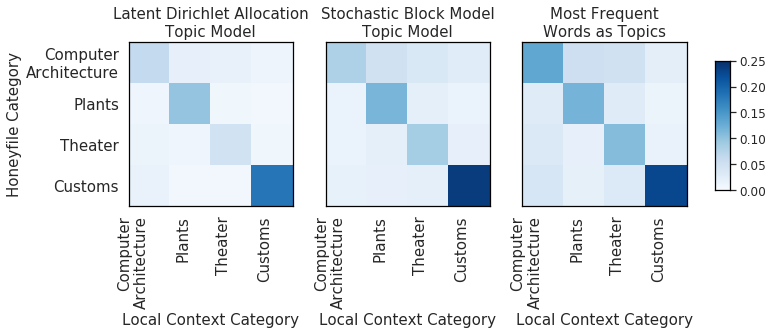

In [7]:
scoring_method = ['lda_score_with_threshold','score_sbmtm_with_threshold','most_frequent_words_threshold']
matrix = np.empty((100000,8), dtype=object)
matrix[:,:]=np.NaN
i=0

with open(path_output+'/local_context_topics_dict_10', 'r') as f:
    topics = json.load(f, object_pairs_hook=collections.OrderedDict)   

for sm in scoring_method:    
    if 'frequent' in sm:
        score = np.load(path_output+ '/' +str(sm) + '_0.9_10_50.npy') 
        with open(path_output+'/local_context_top_50_local_context_size_of_10dict_', 'r') as f:
            topics = json.load(f)        
        topics = OrderedDict(sorted(topics.items()))
    elif 'sbmtm' in sm:
        score = np.load(path_output+ '/' + str(sm)+'_0.9_10.npy')
        with open(path_output+'/SMBTM_local_context_topics_dict_10', 'r') as f:
            topics = json.load(f)        
        topics = OrderedDict(sorted(topics.items())) 
    else:
        score = np.load(path_output+'/'+str(sm)+'_0.9_10.npy')
        with open(path_output+'/local_context_topics_dict_10', 'r') as f:
            topics = json.load(f, object_pairs_hook=OrderedDict)
        topics = OrderedDict(sorted(topics.items()))
     
    categories_vector = []
    for key, value in topics.items():
        categories_vector.extend([key]*len(value))

    score_df = pd.DataFrame(score, index = categories_vector, columns = dec_paths)
    
    del score, topics
    score_df["categories_local_context"] = categories_vector
    score_df = score_df.melt(id_vars=["categories_local_context"], var_name=["dec_paths"], value_name = 'score')
    
    score_df.loc[score_df['dec_paths'].str.contains('customs|ABF|abf|\d{4}-\d{2}'), 'category_deception_file'] = 'customs'
    score_df.loc[score_df['dec_paths'].str.contains('plants|wild-useful-herbs-of-aktobe-region-western'), 'category_deception_file'] = 'plants'
    score_df.loc[score_df['dec_paths'].str.contains('computer|08552374'), 'category_deception_file'] = 'computer'
    score_df.loc[score_df['dec_paths'].str.contains('theater|0021989420918654'), 'category_deception_file'] = 'theater'
    score_df["method"] = np.nan
    score_df.loc[score_df['dec_paths'].str.contains('lorem'), 'method'] = 'lorem'
    score_df.loc[score_df['dec_paths'].str.contains('pos_words'), 'method'] = 'normal'
    score_df.loc[score_df['dec_paths'].str.contains('dependency_parsed_tokens'), 'method'] = 'normal'
    score_df.loc[score_df['dec_paths'].str.contains('gpt_variant2'), 'method'] = 'normal'
    score_df.loc[score_df['dec_paths'].str.contains('gpt_variant1'), 'method'] = 'normal'
    score_df.loc[score_df['dec_paths'].str.contains('unknown'), 'method'] = 'unknown'
    score_df = score_df[~score_df.dec_paths.str.contains("unknown")]
    score_df['score'] = (score_df['score']-min(score_df['score']))/(max(score_df['score'])-min(score_df['score']))
    selection1 = score_df[(score_df['method']=='normal')]
    for cat1 in categories:
        for cat2 in categories:
            selection2 = selection1[(selection1['category_deception_file']==cat1)&(selection1["categories_local_context"]==cat2)]
            matrix[i,0]='normal'
            matrix[i,1]=cat1
            matrix[i,2]=cat2
            matrix[i,3]=50
            matrix[i,4]=np.percentile(selection2['score'],  50)
            matrix[i,5]=sm
            matrix[i,6]=10
            matrix[i,7]=0.9
            i+=1   
            del selection2
    del selection1, score_df

df = hm.data_df(matrix,'threshold')    
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.94, .35, .02, .3])
df['value'] = df['value'].astype(float)

for ss, sm in enumerate(scoring_method):
    data = df[(df['deception file generation method'] == 'normal') & (df['scoring measure'] == sm)\
          & (df['threshold'] == 0.9) & (df['nr. of files per local context'] == 10) & (df['percentile'] == 50)]  
    selection = data['value'].values.reshape([4,4])
    sns.heatmap(selection, xticklabels=labels, yticklabels=labels, cmap="Blues", ax=axs[ss], cbar=True, vmin=0, vmax=.25, cbar_ax=cbar_ax) 
    axs[ss].set_yticklabels(labels, rotation = 0, ha="right", fontsize=15)
    axs[ss].set_xticklabels(labels, rotation = 90, ha="right", fontsize=15)
    axs[0].set_ylabel("Honeyfile Category", fontsize=15)
    axs[ss].set_xlabel("Local Context Category", fontsize=15)
    axs[ss].set(adjustable='box', aspect='equal')
    del data, selection      
    hm.frame(ss, axs)

axs[0].set_title('Latent Dirichlet Allocation\nTopic Model', fontsize=15)
axs[1].set_title('Stochastic Block Model\nTopic Model', fontsize=15)
axs[2].set_title('Most Frequent\nWords as Topics', fontsize=15)

hm.frame(None, cbar_ax)
cbar_ax.set_frame_on(True)

fig.savefig(path_plots + "/figure8.svg", bbox_inches='tight')
fig.show()